## Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from constants import GROUP_TO_ANALYZE, DATES

In [2]:
# import data with pandas
df = pd.read_csv(
    "data/output.csv",
    names=["group", "task", "variant", "time", "status", "student", "achievement"],
)
df.head()

,group,task,variant,time,status,student,achievement
0,1,0,39,2023-02-08 22:09:13.821983,3,1,NaN
1,1,0,38,2023-02-08 22:10:44.827760,2,1,0.0
2,14,0,5,2023-02-09 10:06:55.747618,3,19,NaN
3,14,0,26,2023-02-09 10:07:02.387588,3,3,NaN
4,14,0,5,2023-02-09 10:08:43.042587,3,19,NaN


По времени загрузки ответа, можно анализировать:

1. кто из студентов выбивается из общей картины по времени загрузки ответа в зависимости от типа задания
2. кто из студентов выбивается из общей картины по количеству попыток в зависимости от типа задания


Графики, которые можно сделать:

1. swarmplot по времени загрузки ответа в зависимости от группы, чтобы найти тенденции преуспевающих групп
2. heatmap по студентам, задачам и количеству неудачных попыток в группе, чтобы явно посмотреть на отстающие темы у студентов


## Data preparation


In [3]:
df_dates = pd.DataFrame(
    DATES.items(),
    columns=["task", "task_release_date"],
)
df_dates

,task,task_release_date
0,0,2023-02-08
1,1,2023-02-15
2,2,2023-02-15
3,3,2023-02-15
4,4,2023-02-15
5,5,2023-02-26
6,6,2023-02-26
7,7,2023-03-04
8,8,2023-03-12
9,9,2023-03-18


In [4]:
# dataframe only with one group 1
df_group1 = df[df["group"] == GROUP_TO_ANALYZE]
df_group1.head()

,group,task,variant,time,status,student,achievement
0,1,0,39,2023-02-08 22:09:13.821983,3,1,NaN
1,1,0,38,2023-02-08 22:10:44.827760,2,1,0.0
1090,1,0,14,2023-02-10 14:49:53.406150,3,276,NaN
1104,1,0,14,2023-02-10 14:54:54.093771,3,276,NaN
1696,1,0,14,2023-02-11 02:02:57.995938,3,276,NaN


## Create DataFrame for student-group-task-variant combination


In [5]:
# groupby for "student", "group", "task", "variant" columns
df_gb_student_task_variant = df.groupby(
    ["student", "group", "task", "variant"], as_index=False
)

### Solved column


In [6]:
# create new column
df_student_task_variant = df_gb_student_task_variant.apply(
    lambda x: 2 in x["status"].unique()
)
df_student_task_variant.columns = ["student", "group", "task", "variant", "solved"]
df_student_task_variant

,student,group,task,variant,solved
0,1,1,0,38,True
1,1,1,0,39,False
2,1,4,8,39,False
3,1,6,4,12,False
4,1,14,9,13,False
...,...,...,...,...,...
14898,1736,47,1,30,True
14899,1736,47,2,30,True
14900,1736,47,3,30,True
14901,1736,47,4,30,True


### Solution date column


In [7]:
# create new column
df_solution_date = (
    df[df["status"] == 2]
    .groupby(["student", "group", "task", "variant"], as_index=False)
    .agg(solution_date=("time", "min"))
)
df_solution_date.columns = ["student", "group", "task", "variant", "solution_date"]

# merge new column
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_solution_date,
    on=["student", "group", "task", "variant"],
    how="left",
)
df_student_task_variant

,student,group,task,variant,solved,solution_date
0,1,1,0,38,True,2023-02-08 22:10:44.827760
1,1,1,0,39,False,NaN
2,1,4,8,39,False,NaN
3,1,6,4,12,False,NaN
4,1,14,9,13,False,NaN
...,...,...,...,...,...,...
14898,1736,47,1,30,True,2023-06-06 21:31:46.088896
14899,1736,47,2,30,True,2023-06-06 22:12:52.627125
14900,1736,47,3,30,True,2023-06-06 22:22:37.586111
14901,1736,47,4,30,True,2023-06-06 22:51:04.465129


### First attempt date column


In [8]:
# create new column
df_first_attempt_date = df_gb_student_task_variant.agg(
    first_attempt_date=("time", "min")
)

# merge new column
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_first_attempt_date,
    on=["student", "group", "task", "variant"],
)
df_student_task_variant

,student,group,task,variant,solved,solution_date,first_attempt_date
0,1,1,0,38,True,2023-02-08 22:10:44.827760,2023-02-08 22:10:44.827760
1,1,1,0,39,False,NaN,2023-02-08 22:09:13.821983
2,1,4,8,39,False,NaN,2023-03-15 12:59:28.533969
3,1,6,4,12,False,NaN,2023-02-16 08:58:14.773529
4,1,14,9,13,False,NaN,2023-04-19 21:29:33.411706
...,...,...,...,...,...,...,...
14898,1736,47,1,30,True,2023-06-06 21:31:46.088896,2023-06-06 21:19:23.409904
14899,1736,47,2,30,True,2023-06-06 22:12:52.627125,2023-06-06 22:12:14.461257
14900,1736,47,3,30,True,2023-06-06 22:22:37.586111,2023-06-06 22:22:37.586111
14901,1736,47,4,30,True,2023-06-06 22:51:04.465129,2023-06-06 22:49:47.068341


### First attempt to solution time column


In [9]:
df_student_task_variant["fa_sol_time"] = pd.to_datetime(
    df_student_task_variant["solution_date"]
) - pd.to_datetime(df_student_task_variant["first_attempt_date"])
df_student_task_variant

,student,group,task,variant,solved,solution_date,first_attempt_date,fa_sol_time
0,1,1,0,38,True,2023-02-08 22:10:44.827760,2023-02-08 22:10:44.827760,0 days 00:00:00
1,1,1,0,39,False,NaN,2023-02-08 22:09:13.821983,NaT
2,1,4,8,39,False,NaN,2023-03-15 12:59:28.533969,NaT
3,1,6,4,12,False,NaN,2023-02-16 08:58:14.773529,NaT
4,1,14,9,13,False,NaN,2023-04-19 21:29:33.411706,NaT
...,...,...,...,...,...,...,...,...
14898,1736,47,1,30,True,2023-06-06 21:31:46.088896,2023-06-06 21:19:23.409904,0 days 00:12:22.678992
14899,1736,47,2,30,True,2023-06-06 22:12:52.627125,2023-06-06 22:12:14.461257,0 days 00:00:38.165868
14900,1736,47,3,30,True,2023-06-06 22:22:37.586111,2023-06-06 22:22:37.586111,0 days 00:00:00
14901,1736,47,4,30,True,2023-06-06 22:51:04.465129,2023-06-06 22:49:47.068341,0 days 00:01:17.396788


### Number of first attempt solutions


In [10]:
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_student_task_variant[
        df_student_task_variant["fa_sol_time"].apply(lambda x: x.total_seconds()) == 0
    ]
    .groupby(["student", "variant"], as_index=False)
    .agg(num_fa_sol=("fa_sol_time", "count")),
    how="left",
)
df_student_task_variant.sort_values("num_fa_sol", ascending=False)

,student,group,task,variant,solved,solution_date,first_attempt_date,fa_sol_time,num_fa_sol
14659,1698,29,1,16,True,2023-05-30 14:32:41.597113,2023-05-30 14:32:41.597113,0 days 00:00:00,11.0
14662,1698,29,4,16,True,2023-05-30 14:33:23.860380,2023-05-30 14:33:23.860380,0 days 00:00:00,11.0
6423,736,51,9,9,True,2023-05-30 00:28:39.737866,2023-05-30 00:28:39.737866,0 days 00:00:00,11.0
6424,736,51,10,9,True,2023-05-30 00:29:10.334867,2023-05-30 00:29:10.334867,0 days 00:00:00,11.0
14668,1698,29,10,16,True,2023-05-30 14:34:50.782818,2023-05-30 14:34:50.782818,0 days 00:00:00,11.0
...,...,...,...,...,...,...,...,...,...
14801,1719,47,1,10,True,2023-05-31 17:23:26.387556,2023-05-31 17:22:53.787054,0 days 00:00:32.600502,NaN
14802,1719,47,2,10,True,2023-05-31 17:40:41.099204,2023-05-31 17:37:40.141837,0 days 00:03:00.957367,NaN
14872,1732,30,0,7,True,2023-06-05 02:55:31.202666,2023-06-05 02:34:55.849988,0 days 00:20:35.352678,NaN
14873,1732,30,2,7,False,NaN,2023-06-05 03:15:09.320037,NaT,NaN


### Number of attempts before the solution


In [11]:
temp = pd.merge(
    df,
    df_student_task_variant[
        ["student", "group", "task", "variant", "first_attempt_date", "solution_date"]
    ],
    how="left",
)
temp = temp[temp["solution_date"] > temp["first_attempt_date"]]
temp = temp.groupby(["student", "group", "task", "variant"], as_index=False).agg(
    num_attempts_before_sol=("solution_date", "count")
)
df_student_task_variant = pd.merge(
    df_student_task_variant,
    temp,
    how="left",
)
df_student_task_variant["num_attempts_before_sol"] = np.where(
    df_student_task_variant["fa_sol_time"] == 0,
    0,
    df_student_task_variant["num_attempts_before_sol"],
)
df_student_task_variant

,student,group,task,variant,solved,solution_date,first_attempt_date,fa_sol_time,num_fa_sol,num_attempts_before_sol
0,1,1,0,38,True,2023-02-08 22:10:44.827760,2023-02-08 22:10:44.827760,0 days 00:00:00,1.0,NaN
1,1,1,0,39,False,NaN,2023-02-08 22:09:13.821983,NaT,4.0,NaN
2,1,4,8,39,False,NaN,2023-03-15 12:59:28.533969,NaT,4.0,NaN
3,1,6,4,12,False,NaN,2023-02-16 08:58:14.773529,NaT,NaN,NaN
4,1,14,9,13,False,NaN,2023-04-19 21:29:33.411706,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14898,1736,47,1,30,True,2023-06-06 21:31:46.088896,2023-06-06 21:19:23.409904,0 days 00:12:22.678992,1.0,7.0
14899,1736,47,2,30,True,2023-06-06 22:12:52.627125,2023-06-06 22:12:14.461257,0 days 00:00:38.165868,1.0,2.0
14900,1736,47,3,30,True,2023-06-06 22:22:37.586111,2023-06-06 22:22:37.586111,0 days 00:00:00,1.0,NaN
14901,1736,47,4,30,True,2023-06-06 22:51:04.465129,2023-06-06 22:49:47.068341,0 days 00:01:17.396788,1.0,4.0


### Date gap between task release and first attempt


In [12]:
df_student_task_variant = pd.merge(df_student_task_variant, df_dates)
df_student_task_variant["release_fa_time_gap"] = (
    pd.to_datetime(df_student_task_variant["first_attempt_date"])
    - df_student_task_variant["task_release_date"]
)
df_student_task_variant

,student,group,task,variant,solved,solution_date,first_attempt_date,fa_sol_time,num_fa_sol,num_attempts_before_sol,task_release_date,release_fa_time_gap
0,1,1,0,38,True,2023-02-08 22:10:44.827760,2023-02-08 22:10:44.827760,0 days 00:00:00,1.0,NaN,2023-02-08,0 days 22:10:44.827760
1,1,1,0,39,False,NaN,2023-02-08 22:09:13.821983,NaT,4.0,NaN,2023-02-08,0 days 22:09:13.821983
2,1,43,0,39,False,NaN,2023-02-27 10:02:49.737316,NaT,4.0,NaN,2023-02-08,19 days 10:02:49.737316
3,1,48,0,39,True,2023-02-09 13:35:39.622231,2023-02-09 13:20:36.422438,0 days 00:15:03.199793,4.0,15.0,2023-02-08,1 days 13:20:36.422438
4,1,52,0,39,True,2023-02-09 17:05:48.483566,2023-02-09 17:04:46.001559,0 days 00:01:02.482007,4.0,2.0,2023-02-08,1 days 17:04:46.001559
...,...,...,...,...,...,...,...,...,...,...,...,...
14898,1729,30,5,19,True,2023-06-02 20:04:57.720414,2023-06-02 20:04:57.720414,0 days 00:00:00,9.0,NaN,2023-02-26,96 days 20:04:57.720414
14899,1731,51,5,8,True,2023-06-04 20:49:11.730396,2023-06-04 20:26:21.966139,0 days 00:22:49.764257,1.0,15.0,2023-02-26,98 days 20:26:21.966139
14900,1734,45,5,34,True,2023-06-05 18:36:00.665293,2023-06-05 18:20:45.439016,0 days 00:15:15.226277,2.0,3.0,2023-02-26,99 days 18:20:45.439016
14901,1735,10,5,9,True,2023-06-05 23:46:10.483103,2023-06-05 23:46:10.483103,0 days 00:00:00,3.0,NaN,2023-02-26,99 days 23:46:10.483103


### Number of achievements


In [13]:
temp = (
    df[df["status"] == 2]
    .groupby(["student", "group", "task", "variant"], as_index=False)["achievement"]
    .unique()
)
temp["num_achievement"] = temp["achievement"].apply(lambda x: len(x))
df_student_task_variant = pd.merge(df_student_task_variant, temp, how="left")
df_student_task_variant

,student,group,task,variant,solved,solution_date,first_attempt_date,fa_sol_time,num_fa_sol,num_attempts_before_sol,task_release_date,release_fa_time_gap,achievement,num_achievement
0,1,1,0,38,True,2023-02-08 22:10:44.827760,2023-02-08 22:10:44.827760,0 days 00:00:00,1.0,NaN,2023-02-08,0 days 22:10:44.827760,[0.0],1.0
1,1,1,0,39,False,NaN,2023-02-08 22:09:13.821983,NaT,4.0,NaN,2023-02-08,0 days 22:09:13.821983,NaN,NaN
2,1,43,0,39,False,NaN,2023-02-27 10:02:49.737316,NaT,4.0,NaN,2023-02-08,19 days 10:02:49.737316,NaN,NaN
3,1,48,0,39,True,2023-02-09 13:35:39.622231,2023-02-09 13:20:36.422438,0 days 00:15:03.199793,4.0,15.0,2023-02-08,1 days 13:20:36.422438,[0.0],1.0
4,1,52,0,39,True,2023-02-09 17:05:48.483566,2023-02-09 17:04:46.001559,0 days 00:01:02.482007,4.0,2.0,2023-02-08,1 days 17:04:46.001559,[0.0],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14898,1729,30,5,19,True,2023-06-02 20:04:57.720414,2023-06-02 20:04:57.720414,0 days 00:00:00,9.0,NaN,2023-02-26,96 days 20:04:57.720414,[0.0],1.0
14899,1731,51,5,8,True,2023-06-04 20:49:11.730396,2023-06-04 20:26:21.966139,0 days 00:22:49.764257,1.0,15.0,2023-02-26,98 days 20:26:21.966139,[1.0],1.0
14900,1734,45,5,34,True,2023-06-05 18:36:00.665293,2023-06-05 18:20:45.439016,0 days 00:15:15.226277,2.0,3.0,2023-02-26,99 days 18:20:45.439016,[3.0],1.0
14901,1735,10,5,9,True,2023-06-05 23:46:10.483103,2023-06-05 23:46:10.483103,0 days 00:00:00,3.0,NaN,2023-02-26,99 days 23:46:10.483103,[0.0],1.0


## Plots


### Heatmap


In [14]:
# groupby two columns and count
df_group1[df_group1["status"] == 3].groupby(["student", "task"]).size()

student  task
1        0        3
276      0        3
         1        1
         2        1
         5        3
                 ..
1713     4        2
         6        2
         7       28
         9       29
         10       9
Length: 190, dtype: int64

In [15]:
df_group_1_hm = (
    df_group1[df_group1["status"] == 3]
    .groupby(["student", "task"])
    .size()
    .unstack(level=1)
)
df_group_1_hm = df_group_1_hm.apply(lambda x: x.max() - x)
df_group_1_hm

task,0,1,2,3,4,5,6,7,8,9,10
student,,,,,,,,,,,
1,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,8.0,16.0,14.0,NaN,NaN,49.0,8.0,20.0,40.0,12.0,8.0
313,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
377,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN
868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN
945,NaN,16.0,NaN,5.0,0.0,46.0,0.0,21.0,60.0,38.0,17.0
946,NaN,0.0,12.0,5.0,NaN,15.0,5.0,4.0,0.0,NaN,8.0
948,6.0,16.0,9.0,7.0,NaN,44.0,7.0,8.0,62.0,40.0,15.0
949,0.0,11.0,13.0,9.0,30.0,41.0,6.0,5.0,56.0,40.0,0.0


<Axes: xlabel='task', ylabel='student'>

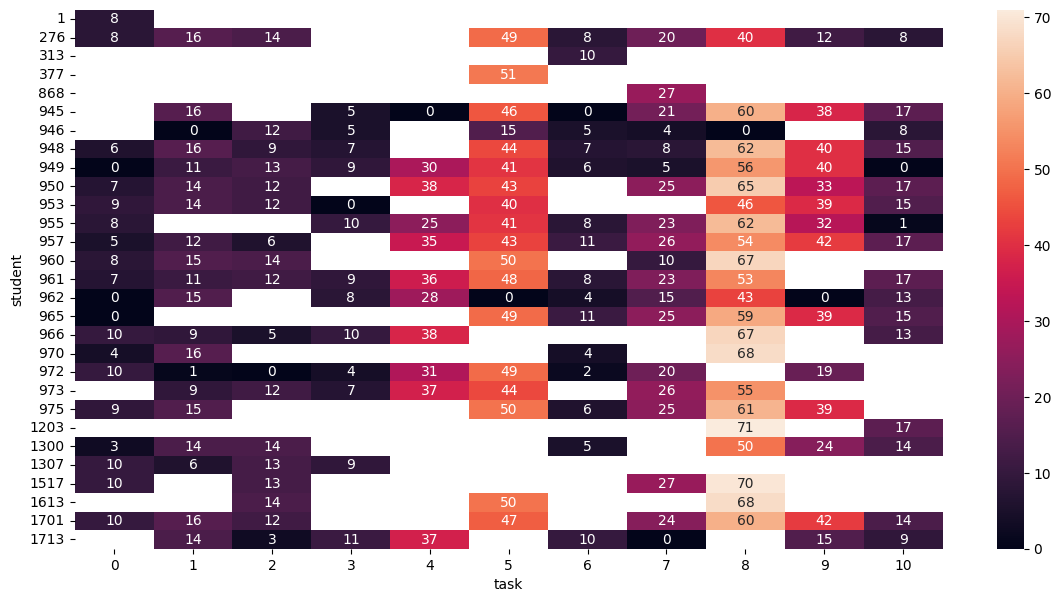

In [16]:
plt.figure(figsize=(14, 7))
sns.heatmap(data=df_group_1_hm, annot=True)

### Boxplot


In [17]:
df_student_group = (
    df_student_task_variant[df_student_task_variant["solved"] == True]
    .groupby(["student", "group"], as_index=False)
    .agg(
        avg_fa_sol_time=("fa_sol_time", "mean"),
        avg_num_attempts_before_sol=("num_attempts_before_sol", "mean"),
        avg_release_fa_time_gap=("release_fa_time_gap", "mean"),
        avg_num_achievement=("num_achievement", "mean"),
    )
)
df_student_group

,student,group,avg_fa_sol_time,avg_num_attempts_before_sol,avg_release_fa_time_gap,avg_num_achievement
0,1,1,0 days 00:00:00,NaN,0 days 22:10:44.827760,1.000000
1,1,42,0 days 00:00:00,NaN,18 days 16:20:08.999713,1.000000
2,1,43,0 days 00:00:19.147333500,2.000000,51 days 23:55:39.558875500,1.000000
3,1,48,0 days 03:31:19.390128,11.800000,15 days 12:43:00.798026142,1.428571
4,1,52,0 days 20:55:18.059835375,2.857143,7 days 23:49:28.357843375,1.125000
...,...,...,...,...,...,...
1449,1732,30,0 days 00:20:35.352678,7.000000,117 days 02:34:55.849988,1.000000
1450,1733,51,0 days 00:02:49.583035800,3.333333,86 days 03:54:31.056453,1.000000
1451,1734,45,0 days 00:03:56.012707800,3.000000,109 days 22:27:11.546056400,1.000000
1452,1735,10,0 days 07:35:39.239115818,6.875000,99 days 01:45:08.646837001,1.000000


<Axes: >

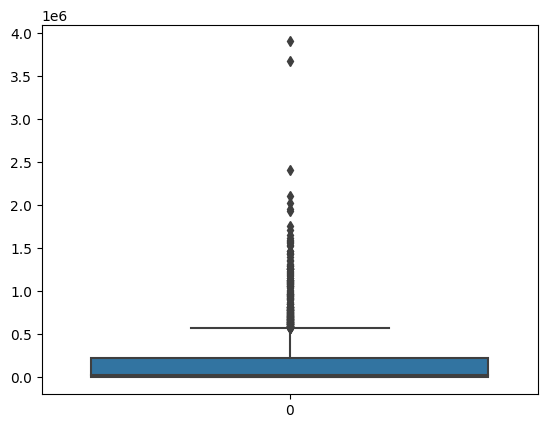

In [18]:
sns.boxplot(df_student_group["avg_fa_sol_time"].dt.total_seconds())

<Axes: >

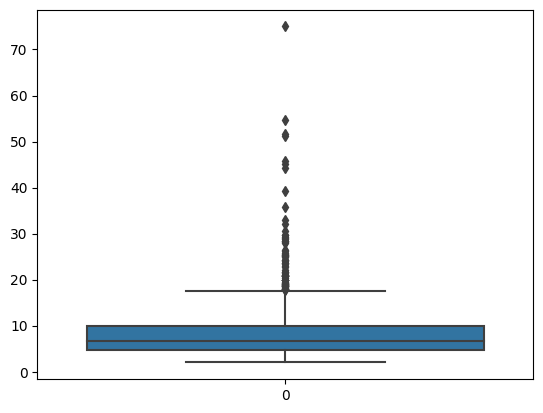

In [20]:
sns.boxplot(df_student_group["avg_num_attempts_before_sol"])

<Axes: >

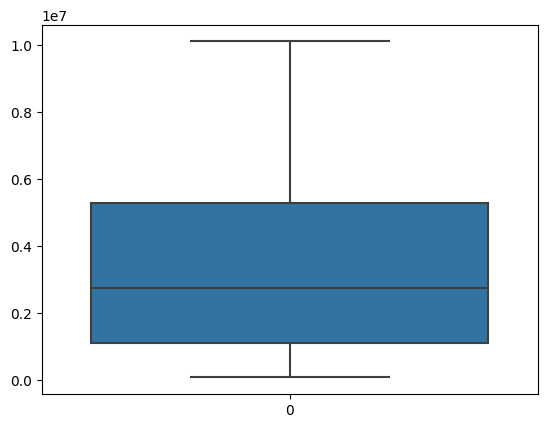

In [21]:
sns.boxplot(df_student_group["avg_release_fa_time_gap"].dt.total_seconds())

<Axes: >

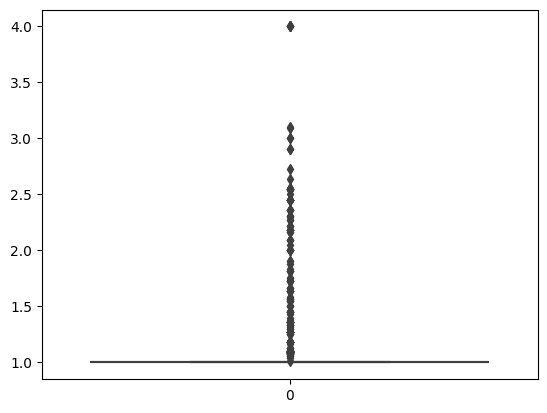

In [22]:
sns.boxplot(df_student_group["avg_num_achievement"])